In [1]:
# === Step 0: Install pybullet (run in Colab) ===
!pip install -q pybullet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# === Step 1: Imports & helpers ===
import os
import time
import numpy as np
import pybullet as p
import pybullet_data
import matplotlib.pyplot as plt

# small helper to save/show images returned from pybullet
def show_rgb_from_px(px, width, height, title=None, save_path=None):
    # px can be a flat tuple/list or already shaped array
    arr = np.array(px, dtype=np.uint8)
    try:
        arr = arr.reshape((height, width, 4))
    except Exception:
        # fallback if already shaped
        pass
    rgb = arr[:, :, :3]  # drop alpha
    plt.figure(figsize=(6,4))
    if title:
        plt.title(title)
    plt.imshow(rgb)
    plt.axis('off')
    if save_path:
        plt.imsave(save_path, rgb)
    plt.show()


In [3]:
# === Step 2: Minimal URDFs (guaranteed to load) ===

# Two-wheel robot
two_wheel_urdf = """<?xml version="1.0"?>
<robot name="two_wheel_robot">
  <link name="base_link">
    <visual>
      <origin xyz="0 0 0.06"/>
      <geometry><box size="0.35 0.25 0.12"/></geometry>
    </visual>
    <collision>
      <origin xyz="0 0 0.06"/>
      <geometry><box size="0.35 0.25 0.12"/></geometry>
    </collision>
  </link>

  <link name="wheel_left">
    <visual>
      <origin xyz="-0.05 0.13 0.03" rpy="0 0 1.5708"/>
      <geometry><cylinder radius="0.05" length="0.02"/></geometry>
    </visual>
    <collision>
      <origin xyz="-0.05 0.13 0.03" rpy="0 0 1.5708"/>
      <geometry><cylinder radius="0.05" length="0.02"/></geometry>
    </collision>
  </link>

  <joint name="left_wheel_joint" type="continuous">
    <parent link="base_link"/>
    <child link="wheel_left"/>
    <origin xyz="-0.05 0.13 0.03"/>
    <axis xyz="0 1 0"/>
  </joint>

  <link name="wheel_right">
    <visual>
      <origin xyz="-0.05 -0.13 0.03" rpy="0 0 1.5708"/>
      <geometry><cylinder radius="0.05" length="0.02"/></geometry>
    </visual>
    <collision>
      <origin xyz="-0.05 -0.13 0.03" rpy="0 0 1.5708"/>
      <geometry><cylinder radius="0.05" length="0.02"/></geometry>
    </collision>
  </link>

  <joint name="right_wheel_joint" type="continuous">
    <parent link="base_link"/>
    <child link="wheel_right"/>
    <origin xyz="-0.05 -0.13 0.03"/>
    <axis xyz="0 1 0"/>
  </joint>
</robot>
"""

# Box
box_urdf = """<?xml version="1.0"?>
<robot name="box_object">
  <link name="box">
    <visual>
      <origin xyz="0 0 0.15"/>
      <geometry><box size="0.3 0.3 0.3"/></geometry>
    </visual>
    <collision>
      <origin xyz="0 0 0.15"/>
      <geometry><box size="0.3 0.3 0.3"/></geometry>
    </collision>
  </link>
</robot>
"""

# Cylinder
cylinder_urdf = """<?xml version="1.0"?>
<robot name="cylinder_object">
  <link name="cyl">
    <visual>
      <origin xyz="0 0 0.2"/>
      <geometry><cylinder radius="0.1" length="0.4"/></geometry>
    </visual>
    <collision>
      <origin xyz="0 0 0.2"/>
      <geometry><cylinder radius="0.1" length="0.4"/></geometry>
    </collision>
  </link>
</robot>
"""

# Wall
wall_urdf = """<?xml version="1.0"?>
<robot name="wall_object">
  <link name="wall">
    <visual>
      <origin xyz="0 0 0.3"/>
      <geometry><box size="1.2 0.1 0.6"/></geometry>
    </visual>
    <collision>
      <origin xyz="0 0 0.3"/>
      <geometry><box size="1.2 0.1 0.6"/></geometry>
    </collision>
  </link>
</robot>
"""

# Table
table_urdf = """<?xml version="1.0"?>
<robot name="table_object">
  <link name="table">
    <visual>
      <origin xyz="0 0 0.25"/>
      <geometry><box size="0.6 0.4 0.5"/></geometry>
    </visual>
    <collision>
      <origin xyz="0 0 0.25"/>
      <geometry><box size="0.6 0.4 0.5"/></geometry>
    </collision>
  </link>
</robot>
"""

# Write them
urdfs = {
    "two_wheel_robot.urdf": two_wheel_urdf,
    "box.urdf": box_urdf,
    "cylinder.urdf": cylinder_urdf,
    "wall.urdf": wall_urdf,
    "table.urdf": table_urdf
}

for fname, content in urdfs.items():
    with open(fname, "w") as f:
        f.write(content)
    print("Wrote", fname)


Wrote two_wheel_robot.urdf
Wrote box.urdf
Wrote cylinder.urdf
Wrote wall.urdf
Wrote table.urdf


In [4]:
# === Step 3: Start PyBullet (DIRECT) and build the scene ===
import os
p.connect(p.DIRECT)  # use p.GUI if running locally
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

# Load plane (from pybullet_data path)
plane_id = p.loadURDF("plane.urdf")

# Base path for our URDF files
base_path = os.getcwd()

# Place objects
objects_to_place = [
    ("box.urdf",     [0.8,  0.0, 0.15], True),
    ("cylinder.urdf",[0.4, -0.6, 0.2], True),
    ("wall.urdf",    [-0.6, 0.5, 0.3], True),
    ("table.urdf",   [-0.8,-0.3, 0.25], True),
    ("box.urdf",     [0.0,  0.7, 0.15], True),
    ("cylinder.urdf",[-0.2,-0.8, 0.2], True),
    ("box.urdf",     [0.6,  0.6, 0.15], True)
]

scene_object_ids = []
scene_positions = []
for (fname, pos, fixed) in objects_to_place:
    path = os.path.join(base_path, fname)
    oid = p.loadURDF(path, basePosition=pos, useFixedBase=fixed)
    scene_object_ids.append(oid)
    scene_positions.append(pos)
    print(f"Loaded {fname} at {pos}")

# Load the robot
robot_start_pos = [-0.9, 0.0, 0.06]
robot_path = os.path.join(base_path, "two_wheel_robot.urdf")
robot_id = p.loadURDF(robot_path, basePosition=robot_start_pos, useFixedBase=False)
scene_positions.append(robot_start_pos)
print("Loaded two_wheel_robot at", robot_start_pos)

# Step simulation
for _ in range(60):
    p.stepSimulation()


Loaded box.urdf at [0.8, 0.0, 0.15]
Loaded cylinder.urdf at [0.4, -0.6, 0.2]
Loaded wall.urdf at [-0.6, 0.5, 0.3]
Loaded table.urdf at [-0.8, -0.3, 0.25]
Loaded box.urdf at [0.0, 0.7, 0.15]
Loaded cylinder.urdf at [-0.2, -0.8, 0.2]
Loaded box.urdf at [0.6, 0.6, 0.15]
Loaded two_wheel_robot at [-0.9, 0.0, 0.06]


In [5]:
# === Step 4: Camera placement helper (auto-fit to scene) ===
def compute_camera_positions(positions, margin_scale=1.2):
    """
    positions: list of [x,y,z] (object base positions used as scene points)
    returns: (camera_positions_list, target_point)
    """
    P = np.array(positions)
    centroid = P.mean(axis=0)
    dists = np.linalg.norm(P - centroid, axis=1)
    max_d = max(0.5, dists.max())  # avoid zero
    # choose camera distance based on spread
    camera_distance = max(1.0, max_d * 2.0 * margin_scale)
    # three viewing vectors at different angles
    cams = [
        centroid + np.array([ camera_distance*0.7,  camera_distance*0.7, camera_distance*0.45]),
        centroid + np.array([-camera_distance*0.8,  camera_distance*0.4, camera_distance*0.55]),
        centroid + np.array([ 0.0, -camera_distance*1.1, camera_distance*0.6])
    ]
    return cams, centroid

cam_positions, scene_centroid = compute_camera_positions(scene_positions)
print("Scene centroid:", scene_centroid)
print("Camera positions:", cam_positions)


Scene centroid: [-0.0875  0.0125  0.1825]
Camera positions: [array([1.43275497, 1.53275497, 1.15980676]), array([-1.82493425,  0.88121712,  1.37698604]), array([-0.0875    , -2.37647209,  1.48557568])]


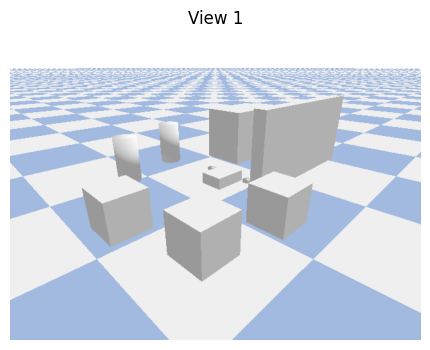

Saved task1_view_1.png


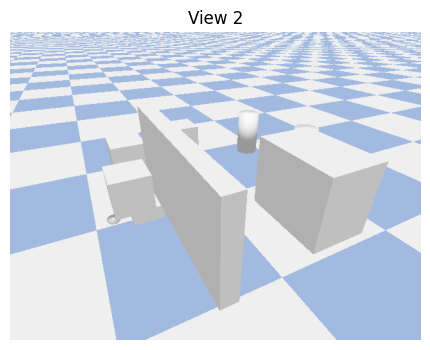

Saved task1_view_2.png


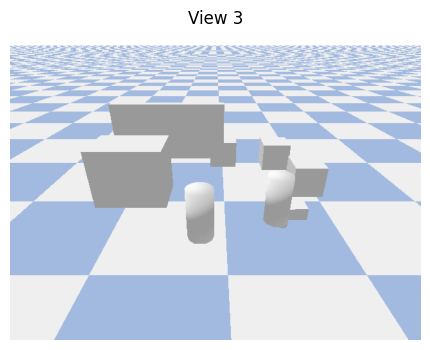

Saved task1_view_3.png


In [6]:
# === Step 5: Move robot between three positions and capture images ===

# Three robot positions (robot moves between the captures; objects remain fixed)
robot_positions_for_views = [
    [-0.5, -0.3, 0.06],
    [ 0.1,  0.6, 0.06],
    [ 0.6, -0.2, 0.06]
]

width = 640
height = 480
fov = 60

captured_images = []
for i, (cam_pos, robot_pos) in enumerate(zip(cam_positions, robot_positions_for_views), start=1):
    # move robot
    p.resetBasePositionAndOrientation(robot_id, robot_pos, [0,0,0,1])
    # step simulation so the scene updates
    for _ in range(40):
        p.stepSimulation()
    # build view & projection matrices
    view_matrix = p.computeViewMatrix(
        cameraEyePosition=cam_pos.tolist(),
        cameraTargetPosition=scene_centroid.tolist(),
        cameraUpVector=[0,0,1]
    )
    proj_matrix = p.computeProjectionMatrixFOV(fov=fov, aspect=float(width)/height, nearVal=0.01, farVal=100)
    img_tuple = p.getCameraImage(width, height, view_matrix, proj_matrix, renderer=p.ER_TINY_RENDERER)
    px = img_tuple[2]  # rgba pixels
    # show and save
    fname = f"task1_view_{i}.png"
    show_rgb_from_px(px, width, height, title=f"View {i}", save_path=fname)
    print("Saved", fname)
    captured_images.append(fname)

# disconnect when finished
p.disconnect()
